In [3]:
%pip install -e ./pysalmcount

Obtaining file:///training/pysalmcount
  Preparing metadata (setup.py) ... done
  Attempting uninstall: pysalmcount
    Found existing installation: pysalmcount 0.1
    Uninstalling pysalmcount-0.1:
      Successfully uninstalled pysalmcount-0.1
  Running setup.py develop for pysalmcount
Note: you may need to restart the kernel to use updated packages.


In [5]:
import datumaro as dm
import os
from os import path as osp
import cv2
from matplotlib import pyplot as plt
import glob
from ultralytics import YOLO
from ultralytics import settings
from pathlib import Path

from collections import defaultdict
import numpy as np
import pandas as pd

import yaml

# Update a setting
settings.update({'runs_dir': '/training/runs'})

DUP_LABELS_MAPPING = {
        'White Fish': 'Whitefish',
        'Bull Trout': 'Bull',
        'Lan prey': 'Lamprey',
        'Lampray': 'Lamprey'
        }

# DataLoader
* data_frames
* load()
* next_frame()
# SalmonCounter
* DataLoader field
* model
* track_history
* LINE_OF_INTEREST_RATIO
* load()
* count()
# Evaluator
* evaluate()

In [6]:
def track_img_frames(model_path, frames_folder):
    botsort='botsort.yaml'
    bytetrack='bytetrack.yaml'
    
    model = YOLO(model_path)
    frames = glob.glob(osp.join(frames_folder, '*.jpg'))
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter('output.mp4', fourcc, 25.0, (1920, 1080))
    for frame in sorted(frames):
        results = model.track(frame, persist=True, tracker=bytetrack)
        
        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        out.write(annotated_frame)

    out.release()

track_img_frames('train_57_no_filt/weights/best.pt', '/mnt/shiorissd4tb/masamim/export_kitwanga_all_yolo/test/09-02-2020_07-49-21_m_salmon_camera/obj_train_data/')
#track_img_frames('train_57_no_filt/weights/best.pt', '/home/masamim/salmon-computer-vision/utils/export_bear_creek_all_yolo/test/09-04-2021_06-42-05_m_network_camera/obj_train_data/')

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'

image 1/1 /mnt/shiorissd4tb/masamim/export_kitwanga_all_yolo/test/09-02-2020_07-49-21_m_salmon_camera/obj_train_data/frame_000000.jpg: 384x640 (no detections), 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /mnt/shiorissd4tb/masamim/export_kitwanga_all_yolo/test/09-02-2020_07-49-21_m_salmon_camera/obj_train_data/frame_000001.jpg: 384x640 (no detections), 5.3ms
Speed: 1.3ms preprocess, 5.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /mnt/shiorissd4tb/masamim/export_kitwanga_all_yolo/test/09-02-2020_07-49-21_m_salmon_camera/obj_train_data/frame_000002.jpg: 384x640 (no detections), 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /mnt/shiorissd4tb/masamim/export_k

In [1]:
import yaml
from pathlib import Path

from pysalmcount.imagedirloader import ImageDirLoader
from pysalmcount.salmon_counter import SalmonCounter

with open('./export_combined_bear_kitwanga_all_yolo/combined_bear_kitwanga_all.yaml', 'r') as file:
    data = yaml.safe_load(file)
d = ImageDirLoader('/home/masamim/salmon-computer-vision/utils/export_bear_creek_all_yolo/test/', 'obj_train_data', data['names'])
#d = ImageDirLoader('/mnt/shiorissd4tb/masamim/export_kitwanga_all_yolo/test/', 'obj_train_data', data['names'])
counter = SalmonCounter('train_57_no_filt/weights/best.pt', d)

def few_clips():
    with open('salm_kitwanga_test.txt', 'r') as f:
        temp = ['/mnt/shiorissd4tb/masamim/export_kitwanga_all_yolo/test/' / Path(x.strip()) for x in f]
        d.num_clips = len(temp)
        d.clip_gen = iter(temp)
        
for i in range(d.clips_len()):
    counter.count(tracker='bytetrack.yaml', save_vid=False, vote_method='confidence', device=2)
#counter.salm_count.to_csv('2021_bearcreek_all_pred_test_ignorethin.csv')
counter.salm_count.to_csv('2021_bearcreek_all_pred_test_bytetrack_confbased.csv')
#counter.salm_count.to_csv('2019_2020_kitwanga_all_pred_test_confbased.csv')

{3: 23.683375895023346}
{11: 3.856683909893036, 3: 1.1667621731758118}
{4: 1.774410605430603, 11: 3.309125006198883}
{4: 0.6291324496269226, 11: 5.373892068862915}
{3: 8.79188659787178, 11: 67.42114147543907, 6: 0.9278726875782013, 4: 18.546856492757797}
{4: 54.1897332072258}
{5: 26.86299604177475, 11: 8.313054144382477}
{6: 162.443101644516}
{6: 132.36823058128357}
{6: 23.914086043834686, 3: 15.276922404766083, 0: 0.9524704813957214}
{6: 2.902730032801628}
{3: 1.5323208570480347}
{6: 10.183174222707748, 3: 28.46746414899826}
{3: 5.654660984873772, 6: 7.445654541254044, 0: 0.8764398396015167}
{4: 7.10984194278717, 6: 1.2689002752304077, 3: 29.412189796566963, 0: 1.230838418006897}
{3: 29.0939382314682}
{0: 7.099287033081055, 6: 1.3290331363677979, 3: 31.36249327659607}
{6: 0.9136710166931152, 3: 31.932876348495483}
{6: 2.862116754055023, 3: 21.30906105041504}
{3: 18.56760859489441}
{6: 89.09439957141876}
{3: 1.771169364452362, 6: 13.539506316184998}
{6: 4.7473993599414825, 11: 8.221205

In [73]:
import yaml
from pathlib import Path

from pysalmcount.datumaroloader import DatumaroLoader
from pysalmcount.salmon_counter import SalmonCounter

with open('2023_combined_salmon.yaml', 'r') as file:
    data = yaml.safe_load(file)
    
d = DatumaroLoader('/mnt/ayumissd4tb/masamim/salm_dataset_bear_2021/', data['names'])
#d = DatumaroLoader('/mnt/ayumissd4tb/masamim/salm_dataset_kitwanga_2019-2020/', data['names'])
#with open('/mnt/ayumissd4tb/masamim/salm_dataset_koeye_kwakwa_2024-03-01/anno_list.txt', 'r') as f:
#    anno_list = [line.strip() for line in f if line.strip()]
#d = DatumaroLoader('/mnt/ayumissd4tb/masamim/salm_dataset_koeye_kwakwa_2024-03-01/', data['names'], anno_list)

def one_clip():
    d.clip_gen = iter(['/home/masamim/salmon-computer-vision/utils/datum_proj_bear_creek_merged_train_split/test/' / Path('09-04-2021_06-53-19_m_network_camera')])
    d.num_clips = 1

#one_clip()

def test():
    d.next_clip()
    items = d.items()
    for i in range(143):
        next(items)
    
    it = next(items)
    print(it.frame)
    print(it.boxes)

#test()

counter = SalmonCounter('train_57_no_filt/weights/best.pt', d, tracking_thresh=10)

csv_out = '2021_bear_all_gt.csv'
#csv_out = '2019-2020_kitwanga_all_gt.csv'
try:
    while True:
        try:
            counter.count(tracker='bytetrack.yaml', use_gt=True, save_vid=False)
        except StopIteration as e:
            raise
        except Exception as e:
            print(e)
            counter.salm_count.to_csv(csv_out)
except StopIteration:
    print("Finish")
counter.salm_count.to_csv(csv_out)
#counter.salm_count.to_csv('2023_koeye_kwakwa_all_gt.csv')

SalmonCounter.count() got an unexpected keyword argument 'stream_write'


TypeError: SalmonCounter.count() got an unexpected keyword argument 'stream_write'

In [1]:
import yaml
from pathlib import Path

from pysalmcount.datumaroloader import DatumaroLoader

with open('2023_combined_salmon.yaml', 'r') as file:
    data = yaml.safe_load(file)
    
d = DatumaroLoader('/mnt/ayumissd4tb/masamim/salm_dataset_koeye_kwakwa_2024-03-01/batch1-pt2/', data['names'])
try:
    while True:
        try:
            name = d.next_clip()
        except NotADirectoryError:
            continue
        print(name)
        print(next(d.items()).frame)
        #with open('sep_vidnames.txt', 'a') as file:
        #    file.write(str(name) + '\n')
except StopIteration:
    pass

/mnt/ayumissd4tb/masamim/salm_dataset_koeye_kwakwa_2024-03-01/batch1-pt2/2023-06-07_15-28-27_koeyefu
/mnt/ayumissd4tb/masamim/salm_dataset_koeye_kwakwa_2024-03-01/batch1-pt2/2023-06-07_15-28-27_koeyefu/images/default/2023-06-07_15-28-27_koeyefu/0000102.png
/mnt/ayumissd4tb/masamim/salm_dataset_koeye_kwakwa_2024-03-01/batch1-pt2/2023-06-07_03-36-48_koeyefu
/mnt/ayumissd4tb/masamim/salm_dataset_koeye_kwakwa_2024-03-01/batch1-pt2/2023-06-07_03-36-48_koeyefu/images/default/2023-06-07_03-36-48_koeyefu/0003535.png


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/ayumissd4tb/masamim/salm_dataset_koeye_kwakwa_2024-03-01/batch1-pt2/2023-06-08_03-19-46_koeyefu/annotations/default.json'

In [14]:
%%bash
#datum project import -p /mnt/ayumissd4tb/masamim/test/ -f datumaro /mnt/ayumissd4tb/masamim/salm_dataset_koeye_kwakwa_2024-03-01/batch1-pt2/datumaro_format/
while IFS= read -r line; do
    datum filter -p /mnt/ayumissd4tb/masamim/test -o "/mnt/ayumissd4tb/masamim/salm_dataset_koeye_kwakwa_2024-03-01/batch1-pt2/$line" -e "/item[id][starts-with(., \"$line\")]"
done < sep_vidnames.txt

2024-03-13 12:15:14,856 INFO: Filtering...
2024-03-13 12:15:17,739 INFO: Results have been saved to '/mnt/ayumissd4tb/masamim/salm_dataset_koeye_kwakwa_2024-03-01/batch1-pt2/2023-06-08_16-16-55_koeyefu'
2024-03-13 12:15:23,933 INFO: Filtering...
2024-03-13 12:15:26,828 INFO: Results have been saved to '/mnt/ayumissd4tb/masamim/salm_dataset_koeye_kwakwa_2024-03-01/batch1-pt2/2023-06-08_00-00-07_koeyefu'
2024-03-13 12:15:33,079 INFO: Filtering...
2024-03-13 12:15:35,989 INFO: Results have been saved to '/mnt/ayumissd4tb/masamim/salm_dataset_koeye_kwakwa_2024-03-01/batch1-pt2/2023-06-08_03-19-46_koeyefu'
2024-03-13 12:15:42,374 INFO: Filtering...
2024-03-13 12:15:45,247 INFO: Results have been saved to '/mnt/ayumissd4tb/masamim/salm_dataset_koeye_kwakwa_2024-03-01/batch1-pt2/2023-06-08_01-15-19_koeyefu'
2024-03-13 12:15:51,463 INFO: Filtering...
2024-03-13 12:15:54,328 INFO: Results have been saved to '/mnt/ayumissd4tb/masamim/salm_dataset_koeye_kwakwa_2024-03-01/batch1-pt2/2023-06-08_01-

In [168]:
import math

FNAME = 'filename'

def split_seqs(df):
    val_split = 0.2
    test_split = 0.2
    df_remain = df.copy(deep=True)
    df_remain = df_remain.sample(frac=1, random_state=40).reset_index() # Shuffle
    
    cols = df_remain.columns.tolist()
    cols[0] = FNAME
    df_remain.columns = cols
    
    distrib = df.sum()
    distrib = distrib[distrib != 0].sort_values()
    print(distrib)
    
    test_c = None
    val_c = None
    def accum_counts(counts, row):
        if counts is None:
            counts = row
        else:
            counts += row

        return counts

    
      # Initialize containers for each split
    train_rows, val_rows, test_rows = [], [], []
    
    for cls, count in distrib.items():
        max_test_count = int(count * test_split)
        max_val_count = int(count * val_split)
        
        df_cls = df_remain[df_remain[cls] != 0]
        
        if len(df_cls) <= 3:
            rows = df_cls.iterrows()
            ind, row = next(rows)
            test_rows.append(row.copy(deep=True))
            test_c = accum_counts(test_c, row)
            df_remain = df_remain[df_remain[FNAME] != row[FNAME]]
            if len(df_cls) > 2:
                ind, row = next(rows)
                val_rows.append(row.copy(deep=True))
                val_c = accum_counts(val_c, row)
                df_remain = df_remain[df_remain[FNAME] != row[FNAME]]
            if len(df_cls) > 1:
                ind, row = next(rows)
                train_rows.append(row.copy(deep=True))
                df_remain = df_remain[df_remain[FNAME] != row[FNAME]]
        else:
            for ind, row in df_cls.iterrows():
                if test_c is None or test_c[cls] < max_test_count:
                    test_rows.append(row.copy(deep=True))
                    test_c = accum_counts(test_c, row)
                elif val_c is None or val_c[cls] < max_val_count:
                    val_rows.append(row.copy(deep=True))
                    val_c = accum_counts(val_c, row)
                else:
                    train_rows.append(row.copy(deep=True))
                    
                df_remain = df_remain[df_remain[FNAME] != row[FNAME]]

    train = pd.DataFrame(train_rows).set_index(FNAME)
    val = pd.DataFrame(val_rows).set_index(FNAME)
    test = pd.DataFrame(test_rows).set_index(FNAME)
    return train, val, test

def sum_lr(df):
    # Sum 'l_' and 'r_' prefixed salmon species counts
    # Assuming the format is 'l_species' and 'r_species'
    species_columns = [col for col in df.columns if col.startswith('l_') or col.startswith('r_')]
    for col in species_columns:
        base_col = col[2:]  # Remove 'l_' or 'r_' prefix
        if 'l_' + base_col in df and 'r_' + base_col in df:
            df[base_col] = df['l_' + base_col].fillna(0) + df['r_' + base_col].fillna(0)
            df.drop(['l_' + base_col, 'r_' + base_col], axis=1, inplace=True)

    return df

    
train, val, test = split_seqs(df_koeye_kwa[df_koeye_kwa.index.str.contains('kwakwa', regex=True, case=False, na=False)])
#train, val, test = split_seqs(df_kit)
f = 'train_splits'
print()
print("TRAIN:")
print(train.sum())
print()
print("VAL:")
print(val.sum())
test.sum()

Cutthroat      4
Pink          13
Coho          76
Sockeye      231
dtype: int64

TRAIN:
Bull             0
Chinook          0
Chum             0
Coho            45
Cutthroat        2
Jack Chinook     0
Jack Coho        0
Lamprey          0
Pikeminnow       0
Pink             9
Rainbow          0
Sculpin          0
Shiner           0
Sockeye         74
Steelhead        0
Stickleback      0
Whitefish        0
dtype: int64

VAL:
Bull              0
Chinook           0
Chum              0
Coho             16
Cutthroat         1
Jack Chinook      0
Jack Coho         0
Lamprey           0
Pikeminnow        0
Pink              2
Rainbow           0
Sculpin           0
Shiner            0
Sockeye         108
Steelhead         0
Stickleback       0
Whitefish         0
dtype: int64


Bull             0
Chinook          0
Chum             0
Coho            15
Cutthroat        1
Jack Chinook     0
Jack Coho        0
Lamprey          0
Pikeminnow       0
Pink             2
Rainbow          0
Sculpin          0
Shiner           0
Sockeye         49
Steelhead        0
Stickleback      0
Whitefish        0
dtype: int64

In [169]:
train.to_csv(f'{f}/train_kwakwa_2023.csv')
val.to_csv(f'{f}/val_kwakwa_2023.csv')
test.to_csv(f'{f}/test_kwakwa_2023.csv')

In [174]:
import pandas as pd
import os

def find_matching_file_paths(csv_file, input_folder, output_file):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file, index_col='filename')
    
    # Get a list of filenames from the DataFrame's index
    filenames = df.index.tolist()
    
    # Prepare a list to hold the matching paths
    matching_paths = []
    
    # Walk through the input folder recursively
    for root, dirs, files in os.walk(input_folder):
        # Check each file in the current directory
        for dir in dirs:
            # If the file matches one of the filenames, add its path to the list
            if dir in filenames:
                full_path = os.path.join(root, dir)
                matching_paths.append(full_path)
    
    # Write the matching paths to the output file
    with open(output_file, 'w') as f:
        for path in matching_paths:
            f.write(path + '\n')

# Example usage
csv_file = 'train_splits/test_koeye_2023.csv'
input_folder = '/mnt/ayumissd4tb/masamim/salm_dataset_koeye_kwakwa_2024-03-01/'
output_file = 'train_splits/out.txt'

find_matching_file_paths(csv_file, input_folder, output_file)

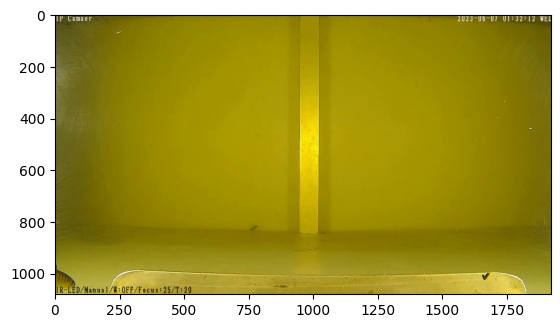

In [29]:
%matplotlib inline
import cv2
from pathlib import Path
from matplotlib import pyplot as plt

main = '/mnt/ayumissd4tb/masamim/salm_dataset_koeye_kwakwa_2024-03-01/'
img = cv2.imread(str(Path(main) / 'batch1-pt2/datumaro_format/images/default/2023-06-07_01-18-15_koeyefu/0003689.png'))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [1]:
import pandas as pd
import yaml
KEY_FILENAME = 'filename'

def load_counts(path):
    return pd.read_csv(path).set_index(KEY_FILENAME)

def get_grouper(df, ignore_class=False):
    if not ignore_class:
        with open('2023_combined_salmon.yaml', 'r') as file:
            data = yaml.safe_load(file)
        classes = data['names'].values()
        def class_check(p, c):
            return p == c[2:]
    else:
        classes = ['l_', 'r_']
        def class_check(p, c):
            return p in c
        
    return [next(p for p in classes if class_check(p,c)) for c in df.columns]

def sum_groups(df, ignore_class=False):
    grouper = get_grouper(df, ignore_class)
    return df.T.groupby(grouper).sum().T

def nmae(gt_path, pred_path, ignore_class=False):
    # Load gt and pred counts
    df_gt = load_counts(gt_path)
    df_pred = load_counts(pred_path)
    
    # Subtract left to left and right to right counts
    df_left_right = df_pred - df_gt
    df_left_right_abs = (df_left_right).abs()
    
    # Sum left and right errors
    df_error = sum_groups(df_left_right_abs, ignore_class)
    
    # Sum left and right gt counts across all clips
    df_gt_sum = sum_groups(df_gt, ignore_class)
    print(df_gt_sum)
    
    # Sum species-specific counting errors across all clips
    df_error_sum = df_error.sum()
    print('-------------Error:')
    print(df_error_sum)
    
    # Divide by sum of gt
    return df_error_sum, df_gt_sum, len(classes)

In [20]:
def load_sum(path):
    df = load_counts(path)
    return sum_groups(df)

df_bear = load_sum('2021_bear_all_gt.csv')
df_kit = load_sum('2019-2020_kitwanga_all_gt.csv')
df_koeye_kwa = load_sum('2023_koeye_kwakwa_all_gt.csv')

df_sum_counts = df_bear.sum() + df_kit.sum() + df_koeye_kwa.sum()
df_sum_counts

Bull             51
Chinook         198
Chum             20
Coho            952
Cutthroat         7
Jack Chinook      5
Jack Coho         0
Lamprey           3
Pikeminnow       47
Pink            854
Rainbow         222
Sculpin           7
Shiner            7
Sockeye         572
Steelhead        22
Stickleback      79
Whitefish        70
dtype: int64

In [144]:
df_bear.sum()

Bull             0
Chinook         21
Chum             0
Coho             3
Cutthroat        0
Jack Chinook     5
Jack Coho        0
Lamprey          0
Pikeminnow       0
Pink            11
Rainbow          0
Sculpin          0
Shiner           0
Sockeye         64
Steelhead        0
Stickleback      0
Whitefish        2
dtype: int64

In [146]:
test

,Bull,Chinook,Chum,Coho,Cutthroat,Jack Chinook,Jack Coho,Lamprey,Pikeminnow,Pink,Rainbow,Sculpin,Shiner,Sockeye,Steelhead,Stickleback,Whitefish
filename,,,,,,,,,,,,,,,,,
09-04-2021_07-04-54_m_network_camera09-05-2021_00-03-05_m_network_camera09-04-2021_07-58-40_m_network_camera09-04-2021_06-22-02_m_network_camera09-04-2021_06-31-42_m_network_camera09-04-2021_06-54-11_m_network_camera08-01-2021_02-29-36_m_salmon_camera09-05-2021_00-10-12_m_network_camera08-03-2021_00-46-06_m_salmon_camera08-01-2021_02-51-21_m_salmon_camera08-01-2021_01-05-07_m_salmon_camera07-30-2021_01-50-54_m_salmon_camera07-31-2021_03-28-41_m_salmon_camera09-02-2021_03-42-19_m_network_camera08-01-2021_01-59-18_m_salmon_camera07-31-2021_00-45-16_m_salmon_camera07-31-2021_03-44-48_m_salmon_camera07-30-2021_01-28-30_m_salmon_camera08-01-2021_02-35-14_m_salmon_camera,0,4,0,1,0,1,0,0,0,2,0,0,0,12,0,0,1
09-05-2021_00-03-05_m_network_camera,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
09-04-2021_07-58-40_m_network_camera,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
09-04-2021_06-22-02_m_network_camera,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
09-04-2021_06-31-42_m_network_camera,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
09-04-2021_06-54-11_m_network_camera,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
08-01-2021_02-29-36_m_salmon_camera,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
09-05-2021_00-10-12_m_network_camera,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
08-03-2021_00-46-06_m_salmon_camera,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [145]:
train.to_csv(f'{f}/train_bear_2021.csv')
val.to_csv(f'{f}/val_bear_2021.csv')
test.to_csv(f'{f}/test_bear_2021.csv')

In [26]:
df_bear.sum()

Bull             0
Chinook         21
Chum             0
Coho             3
Cutthroat        0
Jack Chinook     5
Jack Coho        0
Lamprey          0
Pikeminnow       0
Pink            11
Rainbow          0
Sculpin          0
Shiner           0
Sockeye         64
Steelhead        0
Stickleback      0
Whitefish        2
dtype: int64

In [4]:
def get_upstream_counts(df, contains='koeye', direction='left'):
    print(len(df))
    df = df[df.index.str.contains(contains, regex=True, case=False, na=False)]
    print(len(df))
    df = df.sum()
    if direction == 'left':
        drop_prefix = 'r_'
    else:
        drop_prefix = 'l_'
    c_to_drop = [c for c in df.index if c.startswith(drop_prefix)]
    # Reverse the order of columns, apply .diff(axis=1), and then reverse the columns back
    def maybe_reverse(df_tmp):
        if direction == 'left':
            return df_tmp.iloc[::-1]
        else:
            return df_tmp
    s_data = maybe_reverse(maybe_reverse(df).diff()).drop(c_to_drop)
    rep_reg = '^l_' if direction == 'left' else '^r_'
    s_data.index = s_data.index.str.replace(rep_reg, '', regex=True)
    return s_data

df_koeye_kwa_gt = load_counts('2023_koeye_kwakwa_all_gt.csv')
s_kwakwa_counts = get_upstream_counts(df_koeye_kwa_gt, contains='kwakwa', direction='right')
s_kwakwa_counts.to_csv('2023_kwakwa_gt_upstream_counts.csv')
s_koeye_counts = get_upstream_counts(df_koeye_kwa_gt)
s_koeye_counts.to_csv('2023_koeye_gt_upstream_counts.csv')

df_kit_gt = load_counts('2019-2020_kitwanga_all_gt.csv')
s_kit_counts = get_upstream_counts(df_kit_gt, contains='.*', direction='right')
df_bear_gt = load_counts('2021_bear_all_gt.csv')
s_bear_counts = get_upstream_counts(df_bear_gt, contains='.*', direction='left')

544
152
544
392
1567
1567
123
123


In [10]:
with open('./export_combined_bear_kitwanga_all_yolo/combined_bear_kitwanga_all.yaml', 'r') as file:
    data = yaml.safe_load(file)
list(data['names'].values())

['Coho',
 'Bull',
 'Rainbow',
 'Sockeye',
 'Pink',
 'Whitefish',
 'Chinook',
 'Shiner',
 'Pikeminnow',
 'Chum',
 'Steelhead',
 'Jack Chinook',
 'Lamprey',
 'Cutthroat']

In [42]:
df_error_bear, df_gt_bear, len_classes = nmae('2021_bear_creek_all_gt_test.csv', 'export_bear_creek_all_test.csv', ignore_class=True)
nmae_bear_val = df_error_bear / df_gt_bear
print(nmae_bear_val)
nmae_bear_val.sum() / len_classes

l_Coho             1
r_Coho             0
l_Bull             1
r_Bull             0
l_Rainbow          0
r_Rainbow          0
l_Sockeye         13
r_Sockeye          0
l_Pink             2
r_Pink             0
l_Whitefish        1
r_Whitefish        0
l_Chinook          3
r_Chinook          0
l_Shiner           0
r_Shiner           0
l_Pikeminnow       0
r_Pikeminnow       0
l_Chum             0
r_Chum             0
l_Steelhead        0
r_Steelhead        0
l_Jack Chinook     1
r_Jack Chinook     0
l_Lamprey          0
r_Lamprey          0
l_Cutthroat        0
r_Cutthroat        0
dtype: int64
l_Coho             1
r_Coho             0
l_Bull             0
r_Bull             0
l_Rainbow          0
r_Rainbow          0
l_Sockeye         12
r_Sockeye          0
l_Pink             4
r_Pink             0
l_Whitefish        1
r_Whitefish        0
l_Chinook          7
r_Chinook          0
l_Shiner           0
r_Shiner           0
l_Pikeminnow       0
r_Pikeminnow       0
l_Chum             0


0.18181818181818182

In [37]:
df_error_bear_ign, df_gt_bear_ign, len_classes = nmae('2021_bear_creek_all_gt_test.csv', '2021_bearcreek_all_pred_test_ignorethin.csv', ignore_class=True)
nmae_bear_val_ign = df_error_bear_ign / df_gt_bear_ign
print(nmae_bear_val_ign)
nmae_bear_val_ign.sum() / len_classes

l_    22
r_     0
dtype: int64
-------------Error:
l_    8
r_    0
dtype: int64
l_    0.363636
r_         NaN
dtype: float64


0.18181818181818182

In [5]:
df_error_bear_conf, df_gt_bear_conf, len_classes = nmae('2021_bear_creek_all_gt_test.csv', '2021_bearcreek_all_pred_test_confbased.csv', ignore_class=False)
nmae_bear_val_conf = df_error_bear_conf / df_gt_bear_conf
print(nmae_bear_val_conf)
nmae_bear_val_conf.sum() / len_classes

Bull             1
Chinook          3
Chum             0
Coho             1
Cutthroat        0
Jack Chinook     1
Lamprey          0
Pikeminnow       0
Pink             2
Rainbow          0
Shiner           0
Sockeye         13
Steelhead        0
Whitefish        1
dtype: int64
-------------Error:
Bull            1
Chinook         4
Chum            0
Coho            0
Cutthroat       0
Jack Chinook    0
Lamprey         0
Pikeminnow      0
Pink            2
Rainbow         0
Shiner          0
Sockeye         1
Steelhead       0
Whitefish       0
dtype: int64
Bull            1.000000
Chinook         1.333333
Chum                 NaN
Coho            0.000000
Cutthroat            NaN
Jack Chinook    0.000000
Lamprey              NaN
Pikeminnow           NaN
Pink            1.000000
Rainbow              NaN
Shiner               NaN
Sockeye         0.076923
Steelhead            NaN
Whitefish       0.000000
dtype: float64


0.24358974358974358

In [6]:
df_error_bear_conf, df_gt_bear_conf, len_classes = nmae('2021_bear_creek_all_gt_test.csv', '2021_bearcreek_all_pred_test_bytetrack_confbased.csv', ignore_class=False)
nmae_bear_val_conf = df_error_bear_conf / df_gt_bear_conf
print(nmae_bear_val_conf)
nmae_bear_val_conf.sum() / len_classes

Bull             1
Chinook          3
Chum             0
Coho             1
Cutthroat        0
Jack Chinook     1
Lamprey          0
Pikeminnow       0
Pink             2
Rainbow          0
Shiner           0
Sockeye         13
Steelhead        0
Whitefish        1
dtype: int64
-------------Error:
Bull            1
Chinook         5
Chum            0
Coho            1
Cutthroat       0
Jack Chinook    0
Lamprey         0
Pikeminnow      0
Pink            2
Rainbow         0
Shiner          0
Sockeye         2
Steelhead       0
Whitefish       0
dtype: int64
Bull            1.000000
Chinook         1.666667
Chum                 NaN
Coho            1.000000
Cutthroat            NaN
Jack Chinook    0.000000
Lamprey              NaN
Pikeminnow           NaN
Pink            1.000000
Rainbow              NaN
Shiner               NaN
Sockeye         0.153846
Steelhead            NaN
Whitefish       0.000000
dtype: float64


0.3443223443223444

In [46]:
df_error_kit, df_gt_kit, len_classes = nmae('2019_2021_kitwanga_all_gt_test.csv', '2019_2020_kitwanga_all_pred_test.csv', ignore_class=False)
nmae_kit_val = df_error_kit / df_gt_kit
print(nmae_kit_val)
nmae_kit_val.sum() / len_classes

Bull              5
Chinook          34
Chum              4
Coho            103
Cutthroat         1
Jack Chinook      0
Lamprey           1
Pikeminnow       10
Pink             42
Rainbow           9
Shiner            5
Sockeye          34
Steelhead         3
Whitefish         5
dtype: int64
-------------Error:
Bull             2
Chinook          7
Chum             1
Coho            24
Cutthroat        1
Jack Chinook     0
Lamprey          1
Pikeminnow       4
Pink            12
Rainbow          7
Shiner           5
Sockeye         13
Steelhead        2
Whitefish        5
dtype: int64
Bull            0.400000
Chinook         0.205882
Chum            0.250000
Coho            0.233010
Cutthroat       1.000000
Jack Chinook         NaN
Lamprey         1.000000
Pikeminnow      0.400000
Pink            0.285714
Rainbow         0.777778
Shiner          1.000000
Sockeye         0.382353
Steelhead       0.666667
Whitefish       1.000000
dtype: float64


0.5429574095010172

In [40]:
df_error_kit_ign, df_gt_kit_ign, len_classes_ign = nmae('2019_2021_kitwanga_all_gt_test.csv', '2019_2020_kitwanga_all_pred_test_ignorethin.csv', ignore_class=True)
nmae_kit_val_ign = df_error_kit_ign / df_gt_kit_ign
print(nmae_kit_val_ign)
nmae_kit_val_ign.sum() / len_classes_ign

l_     35
r_    221
dtype: int64
-------------Error:
l_    25
r_    59
dtype: int64
l_    0.714286
r_    0.266968
dtype: float64


0.4906270200387848

In [24]:
df_error_kit_conf, df_gt_kit_conf = nmae('2019_2021_kitwanga_all_gt_test.csv', '2019_2020_kitwanga_all_pred_test_confbased.csv')
nmae_kit_val_conf = df_error_kit_conf / df_gt_kit_conf
print(nmae_kit_val_conf)
nmae_kit_val_conf.sum() / len(data['names'])

Bull              5
Chinook          34
Chum              4
Coho            103
Cutthroat         1
Jack Chinook      0
Lamprey           1
Pikeminnow       10
Pink             42
Rainbow           9
Shiner            5
Sockeye          34
Steelhead         3
Whitefish         5
dtype: int64
-------------Error:
Bull             3
Chinook          7
Chum             1
Coho            23
Cutthroat        1
Jack Chinook     0
Lamprey          1
Pikeminnow       4
Pink            12
Rainbow          7
Shiner           5
Sockeye         13
Steelhead        2
Whitefish        5
dtype: int64
Bull            0.600000
Chinook         0.205882
Chum            0.250000
Coho            0.223301
Cutthroat       1.000000
Jack Chinook         NaN
Lamprey         1.000000
Pikeminnow      0.400000
Pink            0.285714
Rainbow         0.777778
Shiner          1.000000
Sockeye         0.382353
Steelhead       0.666667
Whitefish       1.000000
dtype: float64


0.556549642510726

In [15]:
import seaborn as sns
def plot_scatter(nmae_val):
    plot_params = {
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
        "font.size": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7, 
        "ytick.labelsize": 7, 
        "xtick.labelsize": 7, 
        'legend.fontsize': 7, 
        'legend.title_fontsize': 7,
    }
    sns_params = {
        'figure.figsize': (7.16, 3),
        'figure.dpi': 300,
        "font.size": 7,
        'figure.titlesize': 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7, 
        "ytick.labelsize": 7, 
        "xtick.labelsize": 7, 
        'legend.fontsize': 7, 
        'legend.title_fontsize': 7,
        'lines.linewidth': 0.5,
        'patch.edgecolor': 'black',
    }
    #plot_params['figure.figsize'] = (7.16, 4)
    plot_params['figure.figsize'] = (3.5, 2)
    #plot_params['figure.dpi'] = 96
    plot_params['figure.dpi'] = 300
    #matplotlib.rcParams.update(plot_params)
    
    #sns_params['figure.figsize'] = (7.16, 4)
    sns_params['figure.figsize'] = (3.5, 2)
    #sns_params['figure.dpi'] = 96
    sns_params['figure.dpi'] = 300
    sns_params['patch.edgecolor'] = 'black'
    sns.set_theme("paper", style='whitegrid', rc=sns_params, color_codes=True, palette='tab10')
    #sns.set_context("paper", rc=sns_params)
    #sns.set(rc=sns_params)
    
    sns.set_palette('tab10')
    #g_plot = sns.scatterplot(nmae_val)
    g_plot = sns.barplot(nmae_val)
    g_plot.figure.autofmt_xdate()
    
    axes = g_plot.axes
    axes.legend(loc='upper center', bbox_to_anchor=(0,1.05,1,0.1),
               ncol=2, 
               #mode='expand',
               fancybox=True, frameon=False)
    return g_plot


In [16]:
def plot_save_fig(counts, out_file):
    f = plot_scatter(counts)
    f.figure.savefig(out_file, bbox_inches='tight')
    f.figure.clf()

#plot_save_fig(s_koeye_counts[s_koeye_counts != 0.0].sort_values(ascending=False), 'outputs/2023_koeye_counts.pdf')
#plot_save_fig(s_kwakwa_counts[s_kwakwa_counts != 0.0].sort_values(ascending=False), 'outputs/2023_kwakwa_counts.pdf')
#plot_save_fig(df_sum_counts[df_sum_counts != 0.0].sort_values(ascending=False), 'outputs/2019-2023_salmon_counts.pdf')
plot_save_fig(s_kit_counts[s_kit_counts != 0.0].sort_values(ascending=False), 'outputs/2019-2020_kit_counts.pdf')
plot_save_fig(s_bear_counts[s_bear_counts != 0.0].sort_values(ascending=False), 'outputs/2021_bear_counts.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1050x600 with 0 Axes>

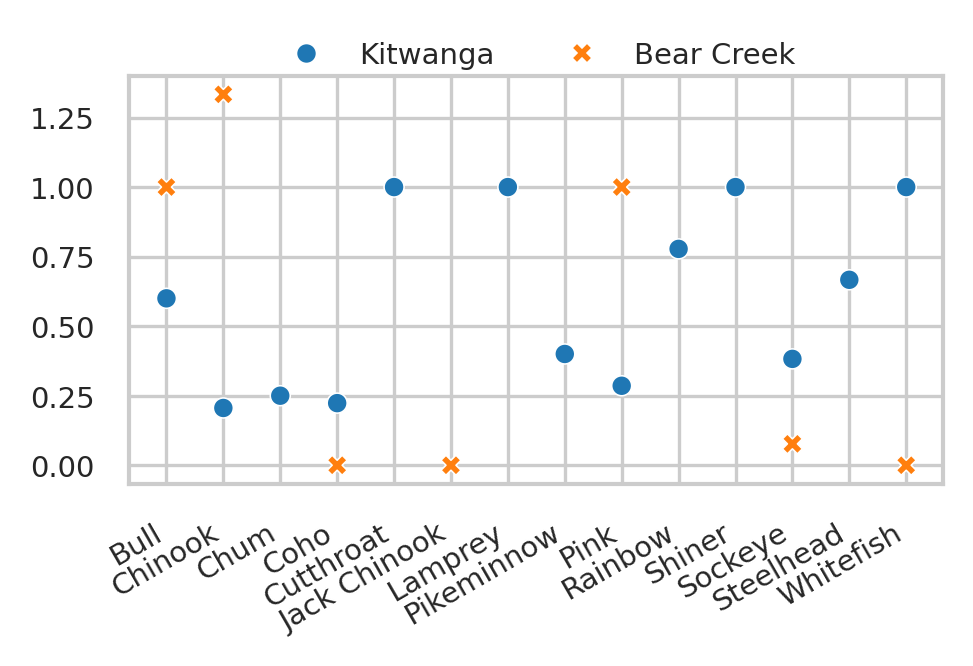

In [19]:
def fix_cols(nmae_1_val, nmae_2_val):
    nmae_val = pd.DataFrame(nmae_1_val)
    nmae_val['Bear Creek'] = nmae_2_val
    nmae_val.rename(columns={0: 'Kitwanga'}, inplace=True)
    return nmae_val
gt_nmae = plot_scatter(fix_cols(nmae_kit_val, nmae_bear_val).dropna(how='all'))
gt_nmae.figure.savefig('outputs/2024-02-09_bear_kit_nmae.pdf', bbox_inches='tight')

<Axes: >

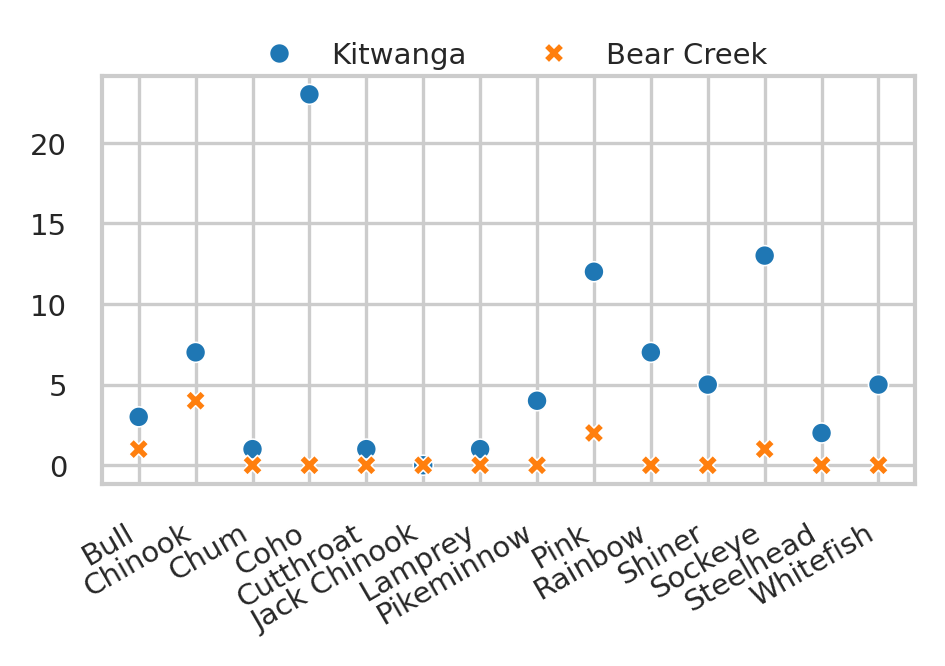

In [22]:
plot_scatter(fix_cols(df_error_kit, df_error_bear).dropna(how='all'))

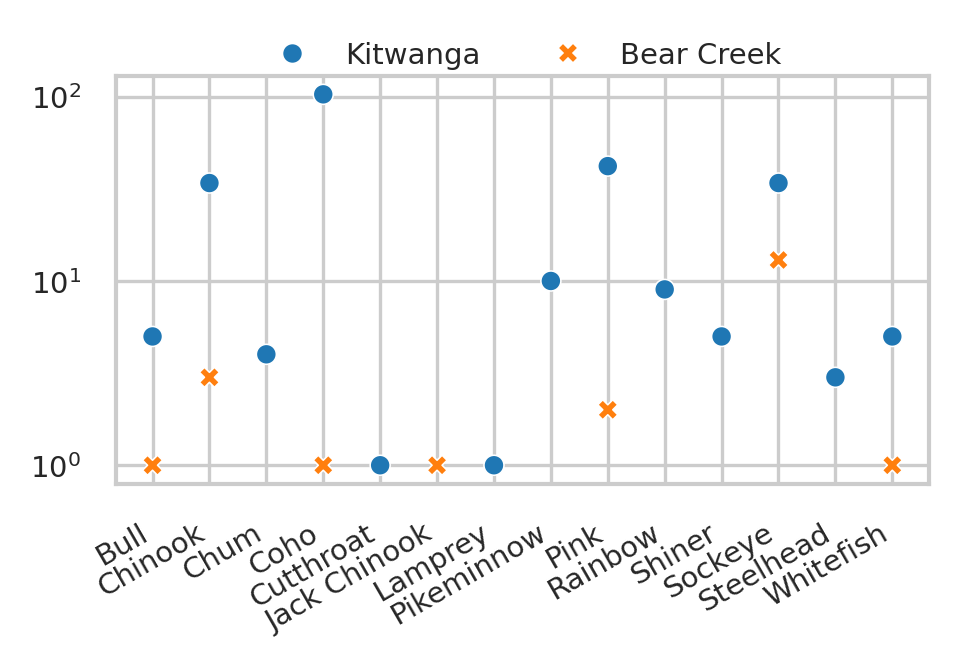

In [23]:
g_gt = plot_scatter(fix_cols(df_gt_kit, df_gt_bear).dropna(how='all'))
g_gt.set(yscale='log')
g_gt.figure.savefig('outputs/2024-02-09_bear_kit_gt_sum.pdf', bbox_inches='tight')

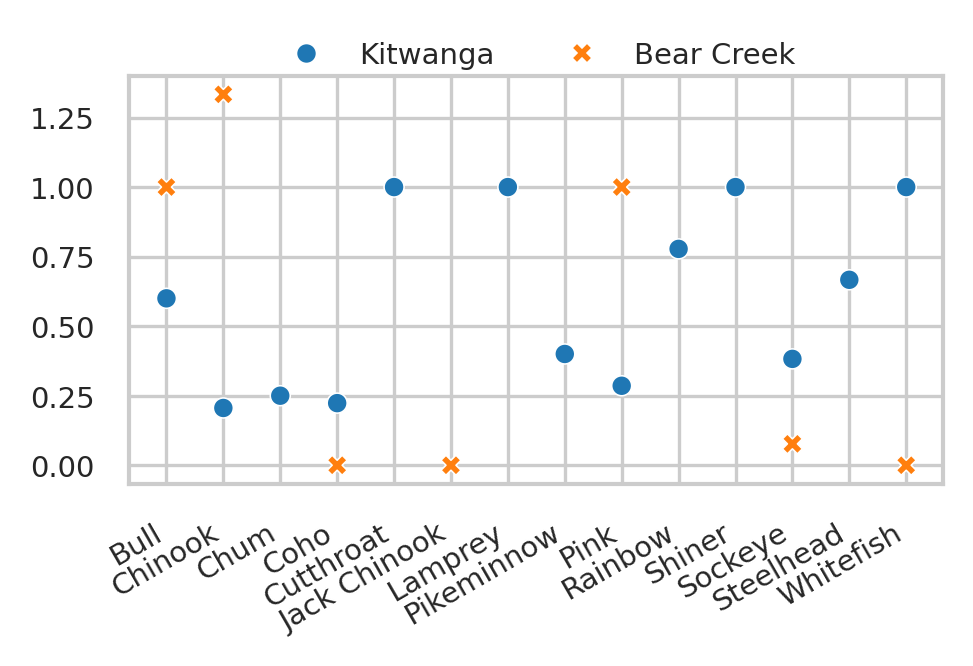

In [27]:
g_gt = plot_scatter(fix_cols(nmae_kit_val_conf, nmae_bear_val_conf).dropna(how='all'))
#g_gt.figure.savefig('outputs/2024-02-09_bear_kit_gt_sum.pdf', bbox_inches='tight')

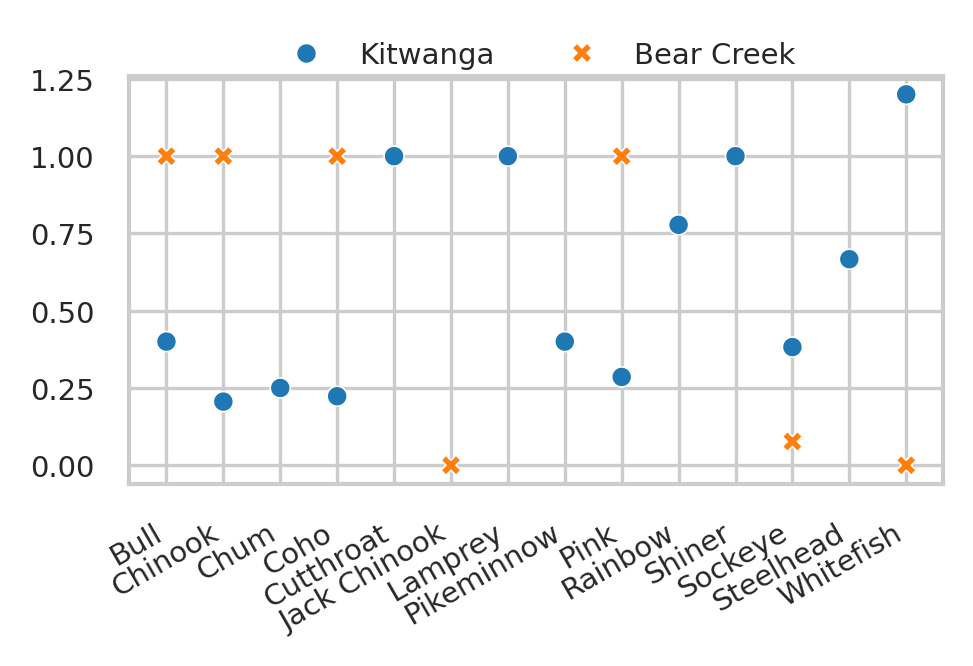

In [30]:
g_gt = plot_scatter(fix_cols(nmae_kit_val_ign, nmae_bear_val_ign).dropna(how='all'))
#g_gt.figure.savefig('outputs/2024-02-09_bear_kit_gt_sum.pdf', bbox_inches='tight')

In [ ]:
# First convert to H264 by runnning `ffmpeg -i output.mp4 test.mp4`
# for v in output_vids/*.mp4; do ffmpeg -i "$v" "bear_creek_count_gt_test/${v##*/}"; done

from IPython.display import Video

Video("bear_creek_count_gt_test/09-04-2021_06-53-19_m_network_camera.mp4", embed=True, width=1280)